# Point Centroid Study

Analyze where the centers of point clusters and, hence, the centers of prostates fall within MRI Scans

### Functions and Imports

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import numpy as np
import math
import os

In [2]:
def load_points(folder):
    points = pd.read_csv(os.path.join(folder, "histmri_controlPoints.csv"), header=None).to_numpy().astype(int)
    hist_points = np.flip(points[:, :2], axis=-1)
    mri_points = np.flip(points[:, 2:], axis=-1)
    return hist_points, mri_points

In [3]:
def calculate_centroid(points):
    return np.mean(points, axis=0)

In [4]:
def euclidean_distance(a, b):
    return math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)

In [5]:
df_ground_truths = pd.read_csv("../data_processing/metadata/ground_truths.csv")
df_valid = df_ground_truths[(df_ground_truths['T2']==1)&(df_ground_truths['PGT Sharp QC']==1)]
base_prostate_directory = "/data/ur/bukowy/LaViolette_Data/Prostates/"

In [6]:
def plot_circle(radius, start_location, c, title):
    angle = np.linspace(0 , 2 * np.pi , 150) 
    x = (radius * np.cos(angle)) +  start_location[1]
    y = (radius * np.sin(angle)) +  start_location[0]
    plt.plot(x, y, color=c, label=title)

In [7]:
def load_mri(filepath):
    """Loads MRI nii file returns a 2D float 32 array of range [0, 1]"""
    mri = nib.load(filepath).get_fdata()
    temp = mri - np.min(mri)
    return (temp / (1 if np.max(temp) == 0 else np.max(temp))).astype(np.float32)

### Intra-Patient Variation Study

We first analyze how the centroids shift on a per-patient level. In theory, the point cloud centroids should be the same for each slide in a patient's scan

In [8]:
centroid_std = []
max_variations = []
min_variations = []
avg_variation = []
patient_centroids = []
for patient in np.unique(df_valid["Patient"]):
    centroid_coords = []
    for slide in df_valid[df_valid["Patient"]==patient]["Slice"]:
        _, mri_points = load_points(os.path.join(base_prostate_directory, str(patient), str(slide)))
        centroid_coords.append(calculate_centroid(mri_points))
    centroid_coords = np.array(centroid_coords)
    patient_centroid = calculate_centroid(centroid_coords)
    patient_centroids.append(patient_centroid)
    
    euclidean_dists = []
    for i in range(len(centroid_coords)):
        euclidean_dists.append(euclidean_distance(centroid_coords[i], patient_centroid))
    centroid_std.append(np.std(euclidean_dists))
    max_variations.append(np.max(euclidean_dists))
    min_variations.append(np.min(euclidean_dists))
    avg_variation.append(np.mean(euclidean_dists))

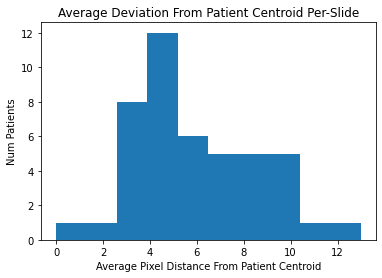

In [9]:
plt.hist(avg_variation)
plt.ylabel("Num Patients")
plt.xlabel("Average Pixel Distance From Patient Centroid")
plt.title("Average Deviation From Patient Centroid Per-Slide")
plt.show()

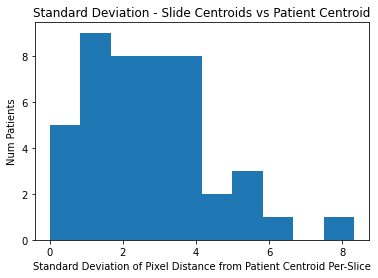

In [10]:
plt.hist(centroid_std)
plt.ylabel("Num Patients")
plt.xlabel("Standard Deviation of Pixel Distance from Patient Centroid Per-Slice")
plt.title("Standard Deviation - Slide Centroids vs Patient Centroid")
plt.show()

### Inter-Patient Study

In [11]:
image_center = [256, 256]

In [12]:
patient_distances = [euclidean_distance(x, image_center) for x in patient_centroids]

In [13]:
print("Max Distance from Image Center", np.max(patient_distances))
p_max = np.unique(df_valid["Patient"])[patient_distances == np.max(patient_distances)][0]
print("Max distance was found in patient", p_max)

Max Distance from Image Center 96.4557477641279
Max distance was found in patient 1128


In [14]:
print("Min Distance from Image Center", np.min(patient_distances))
p_min = np.unique(df_valid["Patient"])[patient_distances == np.min(patient_distances)][0]
print("Min distance was found in patient", p_min)

Min Distance from Image Center 0.9006990907755899
Min distance was found in patient 1200


In [15]:
print("Standard Deviation of Center Deviation", np.std(patient_distances))
print("Average of Center Deviation", np.mean(patient_distances))

Standard Deviation of Center Deviation 20.855948951292326
Average of Center Deviation 35.351764027295104


Text(0.5, 1.0, 'Distances From Center')

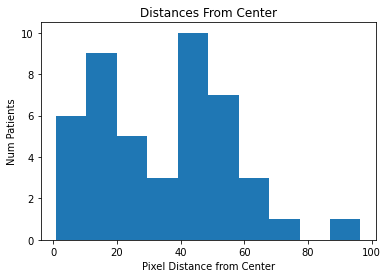

In [16]:
plt.hist(patient_distances)
plt.ylabel("Num Patients")
plt.xlabel("Pixel Distance from Center")
plt.title("Distances From Center")

### Demonstrate

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


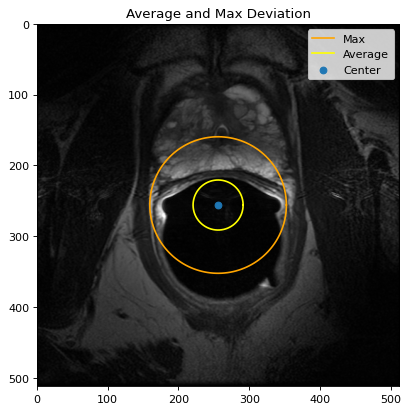

In [17]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
work_dir = os.path.join(base_prostate_directory, str(p_max), str(7))
mri = load_mri(os.path.join(work_dir, "mri_slice_double_T2.nii"))
plt.imshow(mri, cmap="gray")

# Max
plot_circle(np.max(patient_distances), image_center, c="orange", title="Max")

# Average
plot_circle(np.mean(patient_distances), image_center, c="yellow", title="Average")
plt.xlim([0, 512])
plt.ylim([512, 0])

plt.scatter([256], [256], label="Center")
plt.title("Average and Max Deviation")
plt.legend()
plt.show()

In [25]:
def add_gaussian(layer, point, variance=1.0):
    '''
    @param layer: Layer on which to apply a 2D gaussian noise circle. Should be of type float
    @param point: The coordinates of the center of the noise circle (row, col)
    @param variance: The variance of the noise circle

    returns: Existing layer contents + gaussian noise circle centered at point.
             Values in heatmap are normalized between 0 and 1
    referenced: https://github.com/adgilbert/pseudo-image-extraction
    '''
    input_shape = layer.shape
    row_indices, col_indices = np.mgrid[0: input_shape[0], 0: input_shape[1]]
    all_coords = np.column_stack([row_indices.flatten(), col_indices.flatten()])
    cov = np.array([[variance, 0], [0, variance]], dtype=np.float32) 
    result = multivariate_normal.pdf(all_coords, mean=point, cov=cov).reshape(input_shape)
    normalized_result = result / np.amax(result)
    return layer + normalized_result


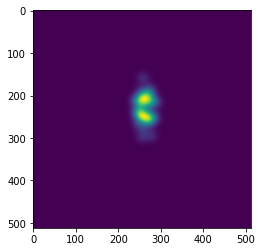

In [38]:
plt.imshow(heatmap)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


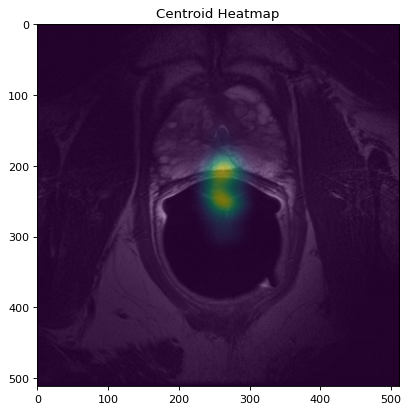

In [43]:
figure(figsize=(8, 6), dpi=80)
work_dir = os.path.join(base_prostate_directory, str(p_max), str(7))
mri = load_mri(os.path.join(work_dir, "mri_slice_double_T2.nii"))
plt.imshow(mri, cmap="gray", origin='upper')
from scipy.stats import multivariate_normal
heatmap = np.zeros((512, 512))
for p in patient_centroids:
    heatmap = add_gaussian(heatmap, p, variance=150) 
plt.imshow(heatmap,alpha=.5, origin='upper')
plt.title("Centroid Heatmap")
plt.show()